In [1]:
%matplotlib inline
import numpy as np
import GP_regressors
import QGP_regressors
 
 
from operator import itemgetter
import matplotlib.pyplot as plt

## latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from scipy.stats import multivariate_normal

import time

from qiskit.quantum_info import Statevector, state_fidelity, partial_trace
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, execute, transpile
from qiskit import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from qiskit.quantum_info import Statevector as st
from qiskit.quantum_info import partial_trace as pt
import scipy

from qiskit.extensions import UnitaryGate, HamiltonianGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit import Aer
from qiskit.circuit.library import QFT
backend = Aer.get_backend("aer_simulator")


In [2]:
##This function makes the plots easy  
def plot_with_uncertainty(Xp, mu, Sigma, color='r', color_samples='b', title="", num_samples=0, name = "Mean", linewidth=2.0, linestyle='-', marker = None, dashes = (1,1)):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    
    # plot distribution
    plt.plot(Xp, mean, color=color,  label=name, linewidth=linewidth, linestyle=linestyle, marker = marker)
    #plt.plot(Xp, mean + 2*std, color=color, linestyle=':')
    #plt.plot(Xp, mean - 2*std, color=color, linestyle=':')
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25)
    
    # generate samples
    if num_samples > 0:
        fs = generate_samples(mu, Sigma, 10)
        plt.plot(Xp, fs, color=color_samples, alpha=.25)
    
    plt.title(title)

In [3]:
## Problem definition
## initial point
x_i = -np.pi/2
x_f = np.pi/2

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze(X_real**2)

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=20).reshape(-1, 1)

## Number of trainning points
np.random.seed(0)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_t = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_t + np.random.normal(0.0, noise_std, size=y_t.shape)

sigma2 = noise_std**2

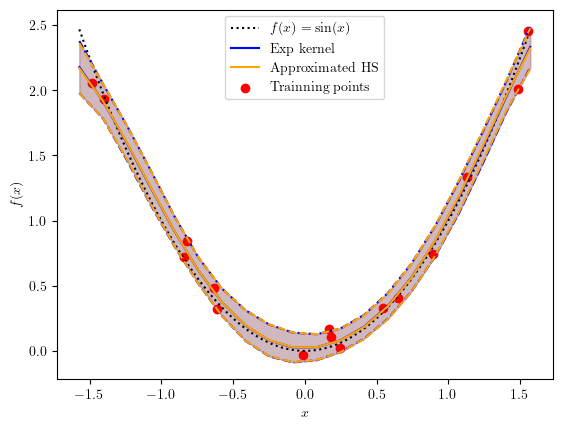

--- 0.6229894161224365 seconds ---


In [4]:
#Models for regression
alpha = 1.5
scale = 1.0

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 3
M = 2**3

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
#plot_with_uncertainty(Xp, mu_post_approx_LP_k, Sigma_post_approx_LP_k, color='green', name = "Approximated LP")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T
Phif.shape, Lambda.shape, Phisf.shape

((16, 8), (8, 8), (8, 20))

In [ ]:
Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))
## Presicion of eigenvalues should be greater than 4
n_eig=16


## delta parameter should be 1>delta>lam_max

delta =np.real(real_eigenvals[0])+0.01

## multiple points mean
R = 4
shots = 10000
mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]




In [ ]:
Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))
## Presicion of eigenvalues should be greater than 4
n_eig=16
## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.01

## multiple points mean
R = 3
shots = 100000
mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]



mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, v_qc = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)

Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

[6.12104459e-01 2.71311196e-01 9.13601994e-02 2.17633946e-02
 3.28424547e-03 1.62231564e-04 1.35443812e-05 7.29933202e-07]


KeyboardInterrupt: 

In [ ]:
# GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = x^2$", linestyle="dotted", color='k')


plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")
plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "Approximated HS QPU")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.savefig("QGP_R4_M4_N16_3_Ne16_Ndelta_xsqrd_8.pdf")

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))


## Other example, Legendre polynomial

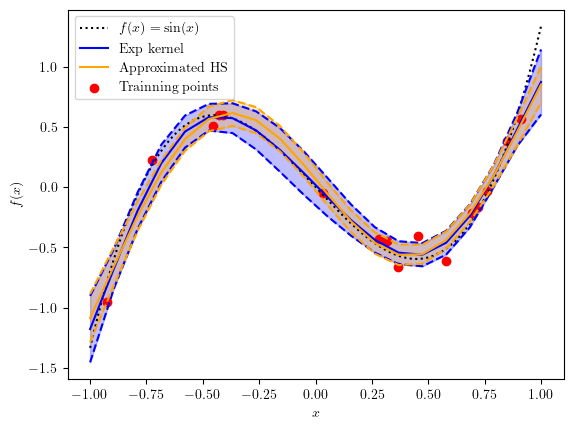

--- 0.7796964645385742 seconds ---


In [ ]:
## initial point
x_i = -1
x_f = 1

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze((5*(X_real)**3 - 3*(X_real))/1.5 )

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=20).reshape(-1, 1)

## Number of trainning points
np.random.seed(2)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_train = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_train + np.random.normal(0.0, noise_std, size=y_train.shape)

sigma2 = noise_std**2
#Models for regression

alpha = 1.0
scale = 0.5

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2
M = 2**2

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T


Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))

## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.05

[0.60507528 0.30513821 0.07059404 0.01919247]


In [ ]:
## Presicion of eigenvalues should be greater than 4
n_eig=16

## multiple points mean
R = 4
shots = 300000
mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]

mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, v_qc = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)

Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

Real eigenvalues:  [0.60507528+0.j 0.30513821+0.j 0.07059404+0.j 0.01919247+0.j]
Quantum eigenvalues:  [0.6050770070020081, 0.3051373739179684, 0.07058931878693264, 0.019191658463737]


KeyboardInterrupt: 

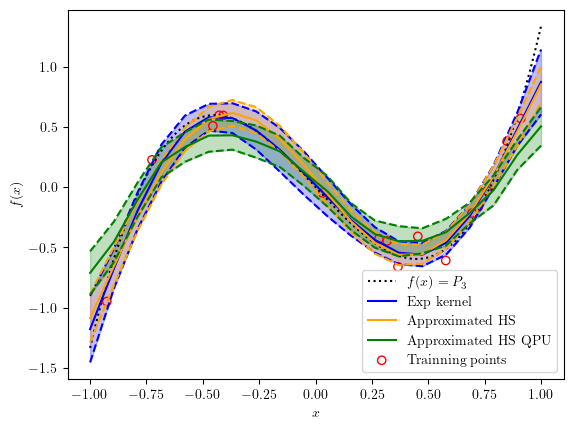

--- 238722.6695742607 seconds ---


In [ ]:
# GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')
plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")
plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "Approximated HS QPU")

plt.scatter(X_train, y_train, marker='o', label="Trainning points", color='r',  facecolors='none')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.savefig("QGP_R4_M4_N16_L2_Ne16_Ndelta_legenP_6.pdf")

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

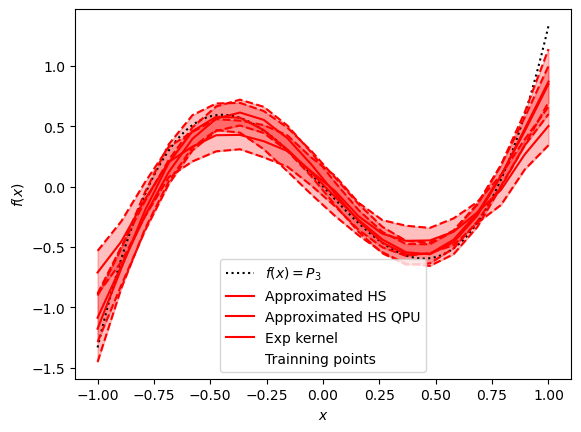

In [ ]:


plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, name = "Approximated HS")
plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, name = "Approximated HS QPU")
plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k,  name = "Exp kernel")
plt.scatter(X_train, y_train, marker='o', label="Trainning points",  facecolors='none')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()


### Legendre poliomial estimation, M = 4

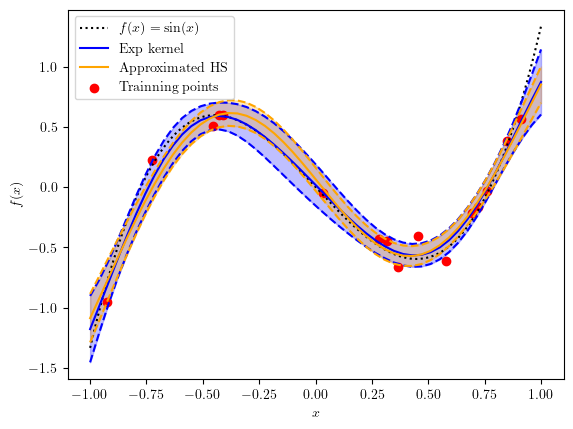

--- 0.13309717178344727 seconds ---


In [ ]:
## initial point
x_i = -1
x_f = 1

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze((5*(X_real)**3 - 3*(X_real))/1.5 )

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=50).reshape(-1, 1)

## Number of trainning points
np.random.seed(2)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_train = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_train + np.random.normal(0.0, noise_std, size=y_train.shape)

sigma2 = noise_std**2
#Models for regression

alpha = 1.0
scale = 0.5

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2
M = 2**2

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T


Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))

## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.01

[0.60507528 0.30513821 0.07059404 0.01919247]


Real eigenvalues:  [0.60507528+0.j 0.30513821+0.j 0.07059404+0.j 0.01919247+0.j]
Quantum eigenvalues:  [0.6050799269221813, 0.3051349999859465, 0.07059625584074464, 0.019192946449657376]
{'0': 149052, '1': 150948}
{'0 0': 138566, '1 0': 86157, '0 1': 38098, '1 1': 37179}
Point:  1  of  20  done.
{'0': 148009, '1': 151991}
{'0 0': 145952, '1 0': 79150, '1 1': 36837, '0 1': 38061}
Point:  2  of  20  done.
{'0': 148172, '1': 151828}
{'0 0': 152114, '1 1': 36608, '1 0': 72632, '0 1': 38646}
Point:  3  of  20  done.
{'1': 152326, '0': 147674}
{'1 1': 36316, '1 0': 69097, '0 0': 155804, '0 1': 38783}
Point:  4  of  20  done.
{'0': 147113, '1': 152887}
{'0 0': 157476, '1 0': 67256, '0 1': 40464, '1 1': 34804}
Point:  5  of  20  done.
{'1': 154613, '0': 145387}
{'1 0': 66591, '1 1': 33042, '0 0': 158502, '0 1': 41865}
Point:  6  of  20  done.
{'1': 155274, '0': 144726}
{'1 0': 66973, '0 1': 43765, '0 0': 158420, '1 1': 30842}
Point:  7  of  20  done.
{'1': 156602, '0': 143398}
{'0 0': 157672, 

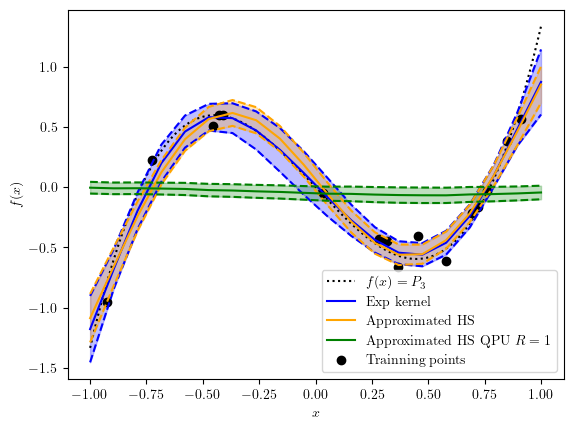

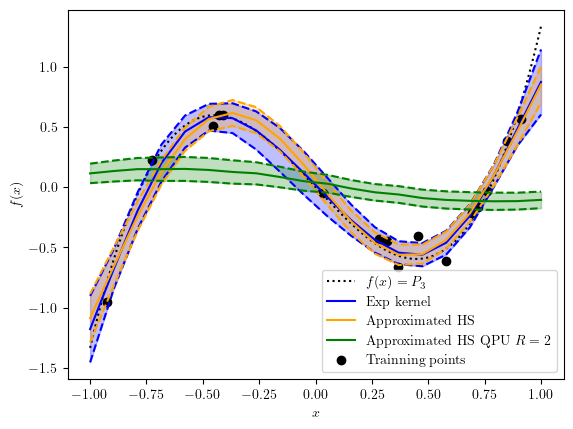

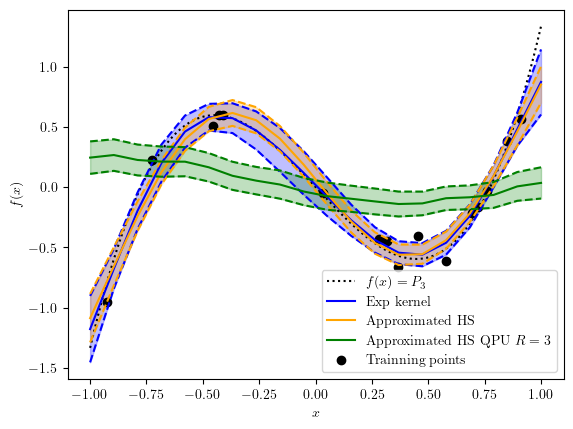

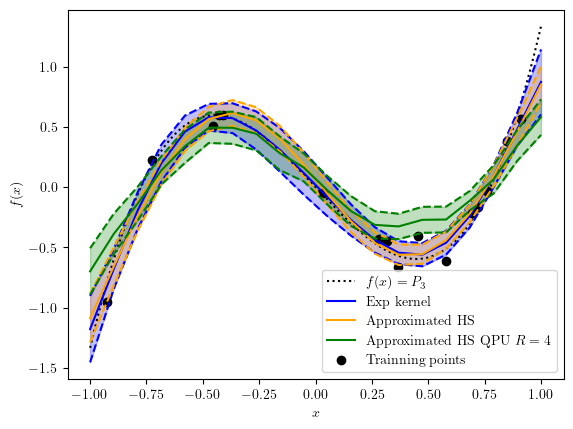

In [ ]:
## Presicion of eigenvalues should be greater than 4
n_eig=16
shots = 300000

## estimate for R = 1,2,3,4
for R in [1,2,3,4]:
    mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]
    mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, v_qc = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)
    Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

    ## save the data in a txt file in columns, just the diagonal of the covariance matrix
    np.savetxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1.txt".format(R,M,N_train,L,n_eig)
                  , np.c_[Xp, mu_post_exp_k, np.diag(Sigma_post_exp_k),
                            mu_post_approx_HS_k, np.diag(Sigma_post_approx_HS_k),
                            mu_post_approx_HS_k_QPU, np.diag(Sigma_post_approx_HS_k_QPU)], delimiter=",")

    ## plot the results in independent figures
    plt.figure()
    plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')
    plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "Approximated HS QPU $R={}$".format(R))

    plt.scatter(X_train, y_train, marker='o', label="Trainning points", color='k')
    
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()

    plt.savefig("Figures/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1.pdf".format(R,M,N_train,L,n_eig))


In [ ]:
## figure with all the results and legend fits
plt.figure(figsize=(8,5))
R = 1
data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1.txt".format(R,M,N_train,L,n_eig), delimiter=",")

for R in [1,2,3,4,5]:
    data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,5], label="HS QPU $R={}$".format(R), color='tab:blue', alpha=R*0.9/4, zorder=0)

plt.plot(data[:,0], data[:,1], color='red', label="GPR", linewidth=4,zorder=0)
plt.plot(data[:,0], data[:,3], color='k', label="HS",zorder=0)
plt.scatter(X_train, y_train, marker='o', color='k',  facecolors='none',zorder=1)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
## place legend outsude the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
## adjust figure size so the legend fits
plt.subplots_adjust(right=0.7)
plt.tight_layout()
plt.savefig("Figures/QGP_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1_means.pdf".format(M,N_train,L,n_eig))




OSError: Figures/data/QGP_R1_M8_N16_L3.141592653589793_Ne16_Ndelta_legenP_1.txt not found.

<Figure size 800x500 with 0 Axes>

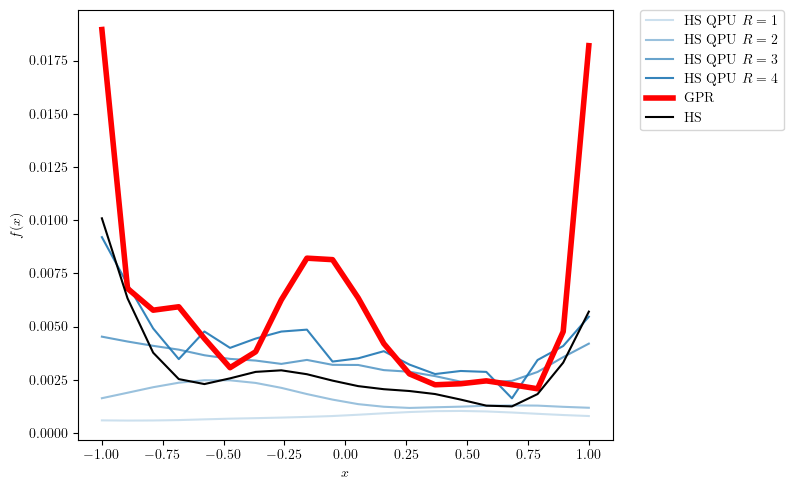

In [ ]:
## figure with all the results and legend fits
plt.figure(figsize=(8,5))

R = 1
data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1.txt".format(R,M,N_train,L,n_eig), delimiter=",")

for R in [1,2,3,4]:
    data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,6], label="HS QPU $R={}$".format(R), color='tab:blue', alpha=R*0.9/4, zorder=0)

plt.plot(data[:,0], data[:,2], color='red', label="GPR", linewidth=4,zorder=0)
plt.plot(data[:,0], data[:,4], color='k', label="HS",zorder=0)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
## place legend outsude the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
## adjust figure size so the legend fits
plt.subplots_adjust(right=0.7)
plt.tight_layout()

plt.savefig("Figures/QGP_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1_variance.pdf".format(M,N_train,L,n_eig))

In [ ]:
10E6

10000000.0

### Legendre poliomial estimation, M = 8

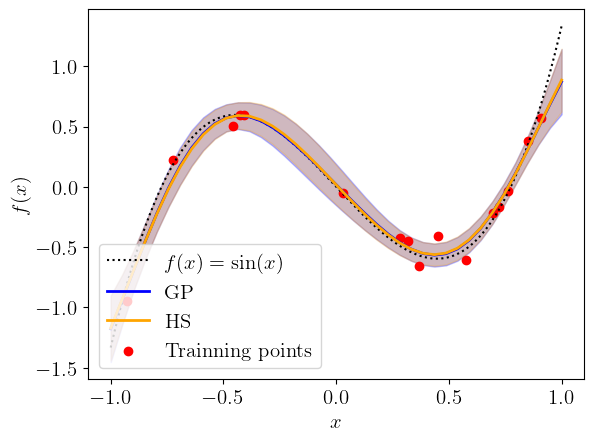

--- 0.2094721794128418 seconds ---


In [10]:
## initial point
x_i = -1
x_f = 1

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze((5*(X_real)**3 - 3*(X_real))/1.5 )

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=40).reshape(-1, 1)

## Number of trainning points
np.random.seed(2)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_train = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_train + np.random.normal(0.0, noise_std, size=y_train.shape)

sigma2 = noise_std**2
#Models for regression

alpha = 1.0
scale = 0.5

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2
M = 2**3

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GP")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T


Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))

## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.01

## Presicion of eigenvalues should be greater than 4
n_eig=16
shots = 1E6

[5.70258371e-01 2.82914596e-01 1.04365848e-01 3.51231912e-02
 6.30237745e-03 9.58002439e-04 7.38727270e-05 3.74117084e-06]


In [117]:

## estimate for R = 2,3,4,5,6
Rs = [2,3,4,5,6]
for R in Rs:
    mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]
    mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, v_qc = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)
    Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

    ## save the data in a txt file in columns, just the diagonal of the covariance matrix
    np.savetxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.txt".format(R,M,N_train,L,n_eig)
                  , np.c_[Xp, mu_post_exp_k, np.diag(Sigma_post_exp_k),
                            mu_post_approx_HS_k, np.diag(Sigma_post_approx_HS_k),
                            mu_post_approx_HS_k_QPU, np.diag(Sigma_post_approx_HS_k_QPU)], delimiter=",")

    ## plot the results in independent figures
    plt.figure()
    plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')
    plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GP")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HS")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "Quantum HS $R={}$".format(R))

    plt.scatter(X_train, y_train, marker='o', label="Trainning points",  color='k')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()

    plt.savefig("Figures/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.pdf".format(R,M,N_train,L,n_eig))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\galvisc1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\galvisc1\AppData\Local\Temp\ipykernel_24688\857653476.py", line 5, in <module>
    mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, v_qc = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)
  File "c:\Users\galvisc1\OneDrive - Aalto University\Documents\Code\QGPR with approx HS\QGP_regressors.py", line 409, in QGPR_approximation_posterior
  File "c:\Users\galvisc1\OneDrive - Aalto University\Documents\Code\QGPR with approx HS\QGP_regressors.py", line 137, in quantum_eigenvals
  File "c:\Users\galvisc1\Anaconda3\lib\site-packages\qiskit_aer\jobs\utils.py", line 42, in _wrapper
    return func(self, *args, **kwargs)
  File "c:\Users\galvisc1\Anaconda3\lib\site-packages\qiskit_aer\jobs\aerjob.py", line 114, in result
    return self._future.result(t

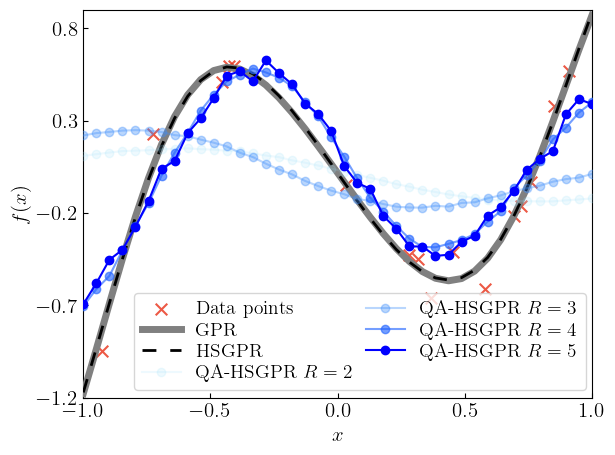

In [5]:
plt.rcParams.update({'font.size': 15})

## colors for the plots
color_GPR = 'gray'
color_HSGPR = 'k'

## red
shades = ['#e66063', '#e35053', '#dd2c2f', '#d02224']

## Blue
shades = ['#97dffc', '#3f8efc', '#2667ff', 'blue']
R = 2
data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.txt".format(R,M,N_train,L,n_eig), delimiter=",")
plt.figure()
plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.plot(data[:,0], data[:,1], color=color_GPR, label="GPR", linewidth=5,zorder=5)

## place ticks inside figure
plt.tick_params(direction='in')

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.32), loc='upper left', borderaxespad=0.)

plt.ylim(-1.2,0.9)
plt.xlim(-1.,1.)

## x ticks interval f 0.5
plt.xticks(np.arange(-1, 1.1, step=0.5))
plt.yticks(np.arange(-1.2, 0.9, step=0.5))
plt.tight_layout()

plt.savefig("Figures/Presentation/mean_GPR.pdf")
plt.plot(data[:,0], data[:,3], color=color_HSGPR, label="HSGPR",zorder=5, ls = '--', dashes=(5, 5), lw = 2)


## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.2), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("Figures/Presentation/mean_HSGPR.pdf")


Rs = [2,3,4,5]
for R in Rs:
    data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,5], 'o-',label="QA-HSGPR $R={}$".format(R), color=shades[R-2], alpha=(R/max(Rs))**2, zorder=5)
    ## place legend left 0.2 units
    plt.legend(bbox_to_anchor=(0.1, 0.02), loc='lower left', fontsize = 14, borderaxespad=0.,ncol=2,labelspacing=0.2,  columnspacing=0.6)

    plt.tight_layout()
    plt.savefig("Figures/Presentation/mean_QHSGPR_p{}.pdf".format(R),  pad_inches = 0, bbox_inches='tight')



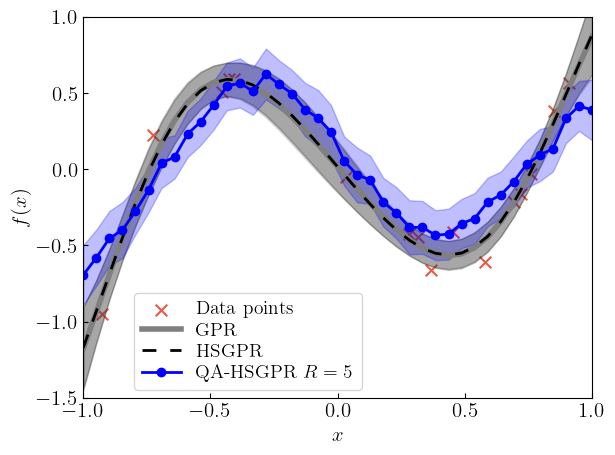

In [13]:
## plot te result with R = 4
R = 5
data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.txt".format(R,M,N_train,L,n_eig), delimiter=",")
#plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')


plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plot_with_uncertainty(Xp, data[:,1], np.diag(data[:,2]), color=color_GPR, name = "GPR", linewidth=4.0, linestyle='solid')
plot_with_uncertainty(Xp, data[:,3], np.diag(data[:,4]), color=color_HSGPR, name = "HSGPR", linestyle=(0, (5, 5)), linewidth=2.0)
plot_with_uncertainty(Xp, data[:,5], np.diag(data[:,6]), color=shades[-1], name = "QA-HSGPR $R={}$".format(R),linestyle='-' ,marker='o')


plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()


## place ticks inside figure
plt.tick_params(direction='in')

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.1, 0.02), loc='lower left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

plt.ylim(-1.5,1.)
plt.xlim(-1.,1.)

## x ticks interval f 0.5
plt.xticks(np.arange(-1, 1.1, step=0.5))
plt.yticks(np.arange(-1.5, 1.2, step=0.5))
plt.tight_layout()

plt.savefig("Figures/Presentation/all_means.pdf".format(R),  pad_inches = 0, bbox_inches='tight')

plt.show()


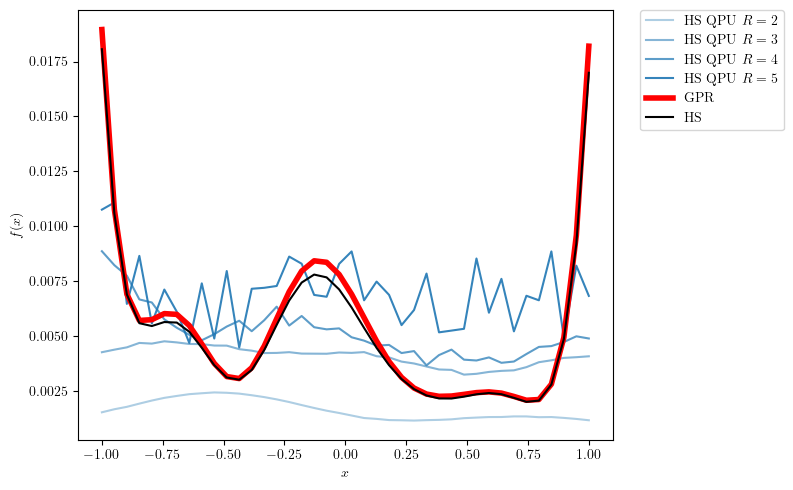

In [ ]:
## figure with all the results and legend fits
plt.figure(figsize=(8,5))

R = 2
data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.txt".format(R,M,N_train,L,n_eig), delimiter=",")
Rs = [2,3,4,5]
for R in Rs:
    data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_40_dp.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,6], label="HS QPU $R={}$".format(R), color='tab:blue', alpha=R*0.9/max(Rs), zorder=0)

plt.plot(data[:,0], data[:,2], color='red', label="GPR", linewidth=4,zorder=0)
plt.plot(data[:,0], data[:,4], color='k', label="HS",zorder=0)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
## place legend outsude the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
## adjust figure size so the legend fits
plt.subplots_adjust(right=0.7)
plt.tight_layout()

plt.savefig("Figures/QGP_M{}_N{}_L{}_Ne{}_Ndelta_legenP_1_variance_40_dp.pdf".format(M,N_train,L,n_eig))



## Sine function approximation


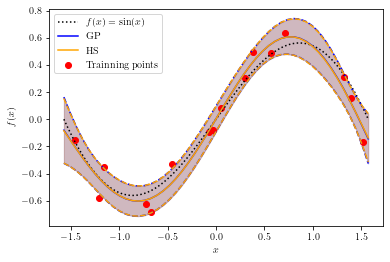

--- 3.4015769958496094 seconds ---


In [ ]:
## initial point
## interval lenght
l_i = np.pi/2
x_i = -l_i
x_f = l_i

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze(X_real* np.cos(X_real))

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=50).reshape(-1, 1)

## Number of trainning points
np.random.seed(24)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_train = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_train + np.random.normal(0.0, noise_std, size=y_train.shape)

sigma2 = noise_std**2
#Models for regression

alpha = 1.2
scale = 1.0

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2*l_i
M = 2**3

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GP")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T


Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))

## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.05

[6.21951004e-01 2.60469438e-01 9.73086493e-02 1.80140122e-02
 2.03488817e-03 1.96590067e-04 2.42779052e-05 1.13993017e-06]


Real eigenvalues:  [6.21951004e-01+0.j 2.60469438e-01+0.j 9.73086493e-02+0.j
 1.80140122e-02+0.j 2.03488817e-03+0.j 1.96590067e-04+0.j
 2.42779052e-05+0.j 1.13993017e-06+0.j]
Quantum eigenvalues:  [0.6219463494338672, 0.26047124187701676, 0.0973127285724597, 0.018014799715710853, 0.002030125409055634, 0.0001948100140002881, 2.050631726318822e-05]
{'1': 621399, '0': 378601}
{'1 0': 273313, '0 0': 429250, '1 1': 92606, '0 1': 204831}
Point:  1  of  50  done.
{'0': 375896, '1': 624104}
{'0 1': 207048, '0 0': 436360, '1 1': 90181, '1 0': 266411}
Point:  2  of  50  done.
{'1': 625510, '0': 374490}
{'0 1': 209837, '1 1': 87196, '1 0': 258978, '0 0': 443989}
Point:  3  of  50  done.
{'0': 372069, '1': 627931}
{'0 0': 451888, '1 0': 251471, '0 1': 211236, '1 1': 85405}
Point:  4  of  50  done.
{'0': 371004, '1': 628996}
{'0 0': 459426, '1 0': 243234, '0 1': 213510, '1 1': 83830}
Point:  5  of  50  done.
{'1': 630045, '0': 369955}
{'1 0': 234927, '0 0': 466909, '0 1': 215782, '1 1': 82382}
Poin

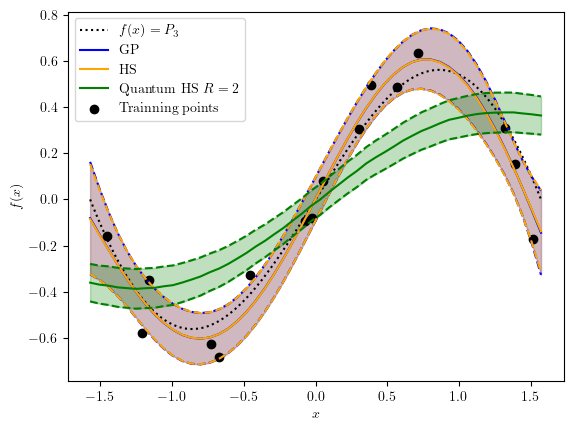

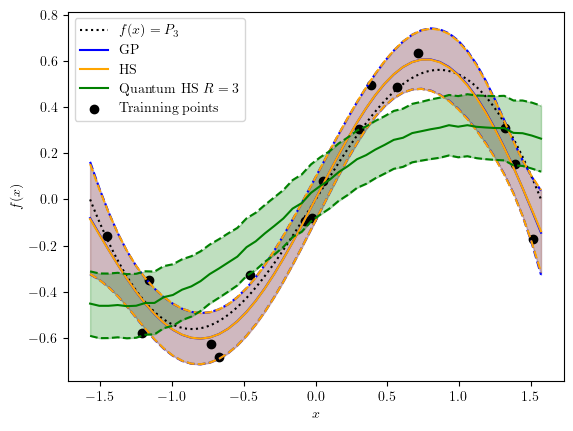

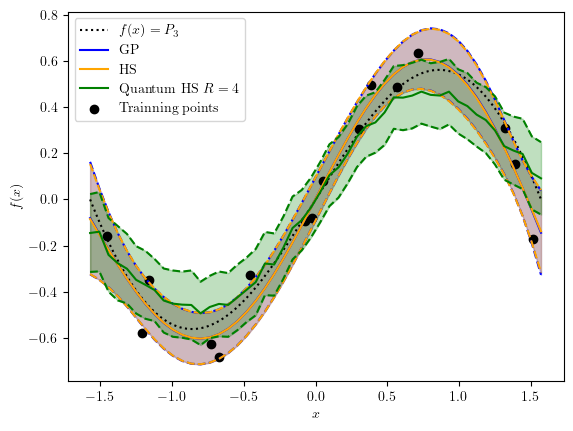

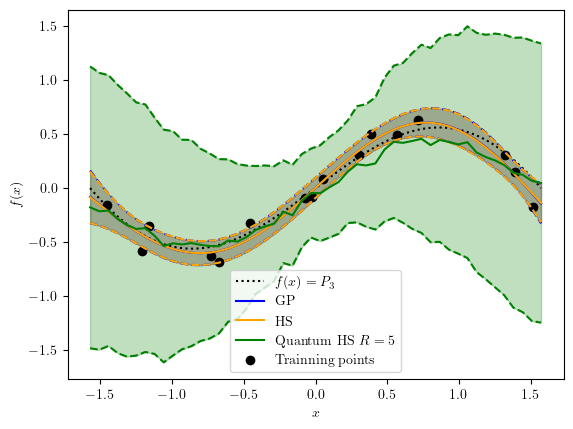

In [ ]:
## Presicion of eigenvalues should be greater than 4
n_eig=16
shots = 1E6

## estimate for R = 2,3,4,5,6
Rs = [2,3,4,5]
for R in Rs:
    mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]
    mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, v_qc = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)
    Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

    ## save the data in a txt file in columns, just the diagonal of the covariance matrix
    np.savetxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_xcos.txt".format(R,M,N_train,L,n_eig)
                  , np.c_[Xp, mu_post_exp_k, np.diag(Sigma_post_exp_k),
                            mu_post_approx_HS_k, np.diag(Sigma_post_approx_HS_k),
                            mu_post_approx_HS_k_QPU, np.diag(Sigma_post_approx_HS_k_QPU)], delimiter=",")

    ## plot the results in independent figures
    plt.figure()
    plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')
    plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GP")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HS")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "Quantum HS $R={}$".format(R))

    plt.scatter(X_train, y_train, marker='o', label="Trainning points",  color='k')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()

    plt.savefig("Figures/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_xcos.pdf".format(R,M,N_train,L,n_eig))

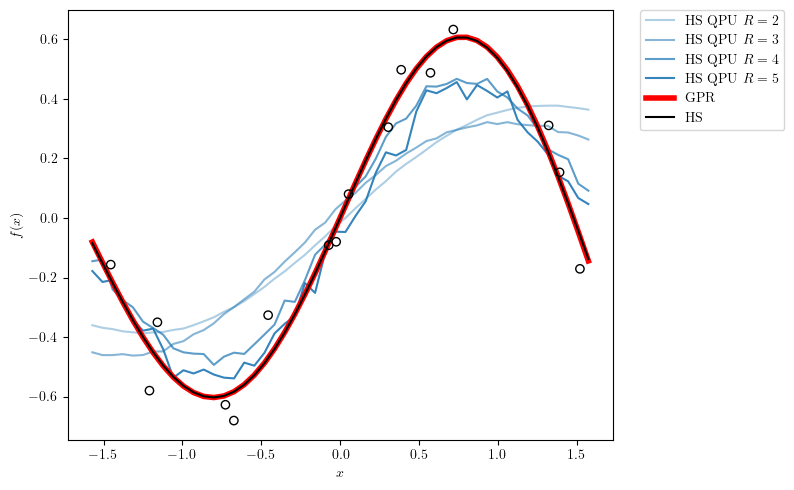

In [ ]:
## figure with all the results and legend fits
plt.figure(figsize=(8,5))
R = 2
data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_xcos.txt".format(R,M,N_train,L,n_eig), delimiter=",")

for R in Rs:
    data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_xcos.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,5], label="HS QPU $R={}$".format(R), color='tab:blue', alpha=R*0.9/max(Rs), zorder=0)

plt.plot(data[:,0], data[:,1], color='red', label="GPR", linewidth=4,zorder=0)
plt.plot(data[:,0], data[:,3], color='k', label="HS",zorder=0)
plt.scatter(X_train, y_train, marker='o', color='k',  facecolors='none',zorder=1)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
## place legend outsude the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
## adjust figure size so the legend fits
plt.subplots_adjust(right=0.7)
plt.tight_layout()
plt.savefig("Figures/QGP_M{}_N{}_L{}_Ne{}_Ndelta_xcos_mean.pdf".format(M,N_train,L,n_eig))



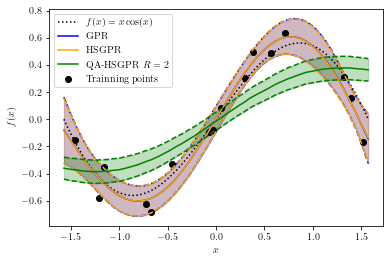

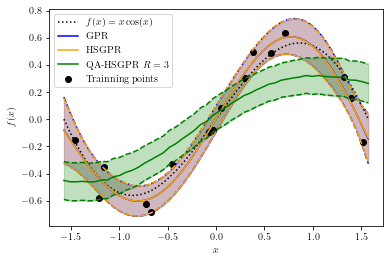

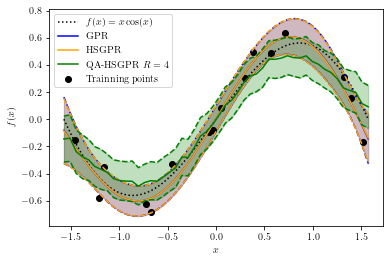

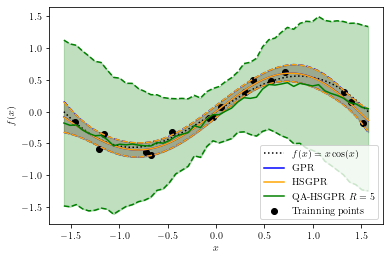

In [ ]:
## Presicion of eigenvalues should be greater than 4
n_eig=16

## estimate for R = 2,3,4,5,6
Rs = [2,3,4,5]
for R in Rs:

    ## load de data
    data = np.loadtxt("Figures/data/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_xcos.txt".format(R,M,N_train,L,n_eig), delimiter=",")

    ## plot the results in independent figures
    plt.figure()
    plt.plot(X_real, y, label=r"$f(x) = x\cos(x)$", linestyle="dotted", color='k')
    plot_with_uncertainty(Xp, data[:,1], np.diag(data[:,2]), color='blue', name = "GPR")
    plot_with_uncertainty(Xp, data[:,3], np.diag(data[:,4]), color='orange', name = "HSGPR")
    plot_with_uncertainty(Xp, data[:,5], np.diag(data[:,6]), color='green', name = "QA-HSGPR $R={}$".format(R))

    plt.scatter(X_train, y_train, marker='o', label="Trainning points",  color='k')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()

    plt.savefig("Figures/Presentation/QGP_xcos_{}.pdf".format(R-1))

## Ahmad sine example.

In [153]:
## Problem definition
## initial point
x_i = -np.pi
x_f = np.pi

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze(np.sin(X_real))

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=50).reshape(-1, 1)

## Number of trainning points
np.random.seed(24)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_t = X_real[training_indices], y[training_indices]


## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_t + np.random.normal(0.0, noise_std, size=y_t.shape)

sigma2 = noise_std**2

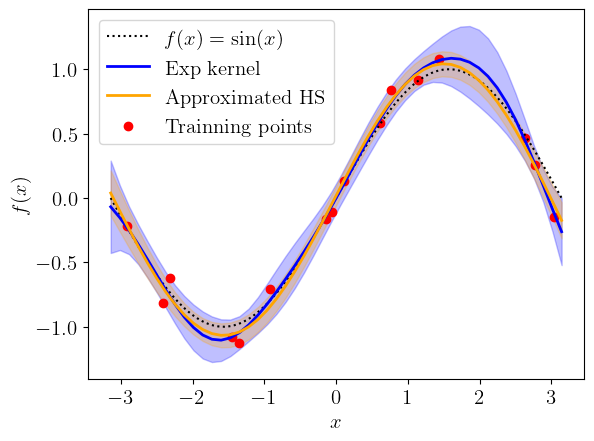

--- 0.18699407577514648 seconds ---


In [154]:
#Models for regression
alpha = 1.5
scale = 1.0

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2*np.pi
M = 2**2

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "Exp kernel")
#plot_with_uncertainty(Xp, mu_post_approx_LP_k, Sigma_post_approx_LP_k, color='green', name = "Approximated LP")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "Approximated HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [155]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

M = 4
N_train = 16
n_eig = 13

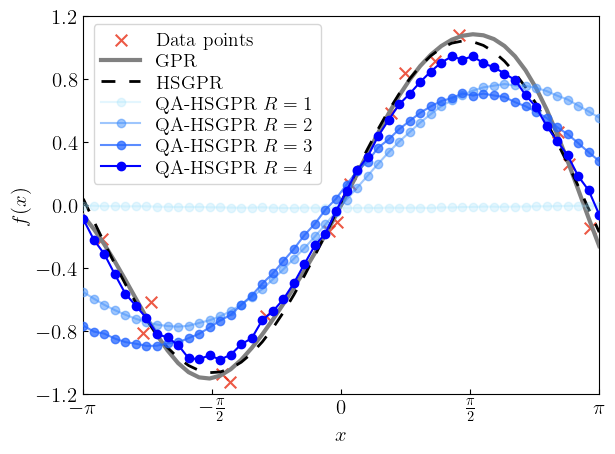

In [156]:
## colors for the plots
color_GPR = 'gray'
color_HSGPR = 'k'

## red
shades = ['#e66063', '#e35053', '#dd2c2f', '#d02224']

## Blue
shades = ['#97dffc', '#3f8efc', '#2667ff', '#0000ff']

R = 2

data = np.loadtxt("Figures/data/AFdata/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_6.txt".format(R,M,N_train,L,n_eig), delimiter=",")
plt.figure()
plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.plot(data[:,0], data[:,1], color=color_GPR, label="GPR", linewidth=3,zorder=5)

## place ticks inside figure
plt.tick_params(direction='in')



plt.ylim(-1.2,1.2)
plt.xlim(-np.pi,np.pi)

plt.yticks(np.arange(-1.2, 1.3, step=0.4))

tick_pos= [-np.pi , -np.pi/2, 0 , np.pi/2, np.pi]
labels = [r'$-\pi$', r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
plt.xticks(tick_pos, labels)

plt.tight_layout()

plt.savefig("Figures/data/AFdata/mean_GPR.pdf")
## linestyle dashed more spaced
plt.plot(data[:,0], data[:,3], color=color_HSGPR, label="HSGPR",zorder=5, ls = '--', dashes=(5, 5), linewidth = 2.)


## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.32), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("Figures/data/AFdata/mean_HSGPR.pdf")


Rs = [1,2,3,4]
for R in Rs:
    data = np.loadtxt("Figures/data/AFdata/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_6.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,5], 'o-', label="QA-HSGPR $R={}$".format(R), color=shades[R-1], alpha=(R/max(Rs))**1, zorder=5)
    ## place legend left 0.2 units
    plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

    plt.tight_layout()
    plt.savefig("Figures/data/AFdata/mean_QHSGPR_p{}.pdf".format(R),  pad_inches = 0, bbox_inches='tight')

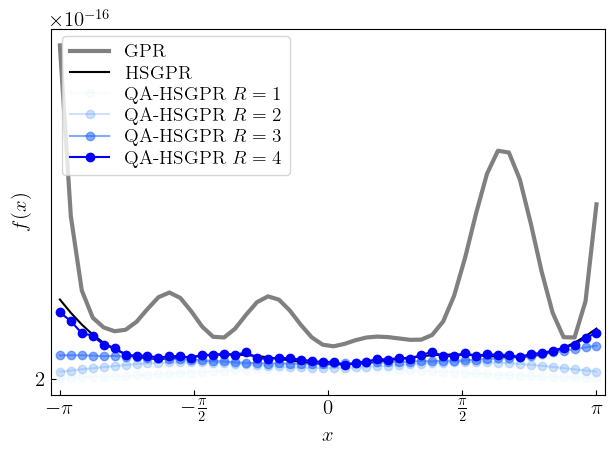

In [157]:
## colors for the plots
color_GPR = 'gray'
color_HSGPR = 'k'
## red
#shades = ['#e66063', '#e35053', '#dd2c2f', '#d02224']

R = 2
data = np.loadtxt("Figures/data/AFdata/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_6.txt".format(R,M,N_train,L,n_eig), delimiter=",")
plt.figure()

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.plot(data[:,0], data[:,2], color=color_GPR, label="GPR", linewidth=3,zorder=0)

## place ticks inside figure
plt.tick_params(direction='in')

plt.xlim(-np.pi-0.1,np.pi+0.1)

plt.yticks(np.arange(-1.2, 1.3, step=0.3))

tick_pos= [-np.pi , -np.pi/2, 0 , np.pi/2, np.pi]
labels = [r'$-\pi$', r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
plt.xticks(tick_pos, labels)

plt.tight_layout()

plt.savefig("Figures/data/AFdata/var_GPR.pdf")
plt.plot(data[:,0], data[:,4], color=color_HSGPR, label="HSGPR",zorder=0)

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.32), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("Figures/data/AFdata/mean_HSGPR.pdf")


Rs = [1,2,3,4]
for R in Rs:
    data = np.loadtxt("Figures/data/AFdata/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_6.txt".format(R,M,N_train,L,n_eig), delimiter=",")
    plt.plot(data[:,0], data[:,6], 'o-', label="QA-HSGPR $R={}$".format(R), color=shades[R-1], alpha=(R/max(Rs))**2, zorder=0)
    ## place legend left 0.2 units
    plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

    plt.tight_layout()
    plt.savefig("Figures/data/AFdata/var_QHSGPR_p{}.pdf".format(R),  pad_inches = 0, bbox_inches='tight')



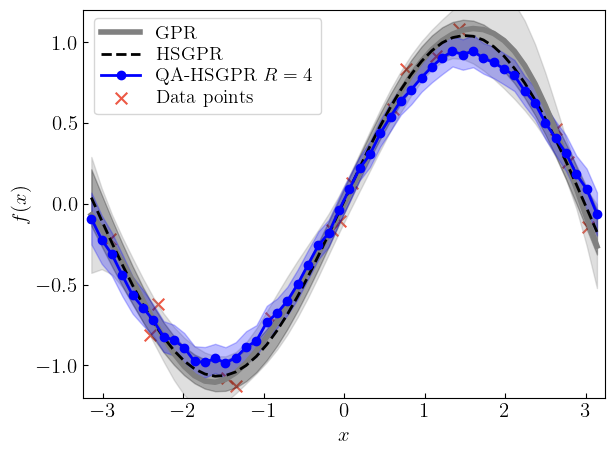

In [158]:
## plot te result with R = 4
R = 4
data = np.loadtxt("Figures/data/AFdata/QGP_R{}_M{}_N{}_L{}_Ne{}_Ndelta_legenP_6.txt".format(R,M,N_train,L,n_eig), delimiter=",")
#plt.plot(X_real, y, label=r"$f(x) = P_3$", linestyle="dotted", color='k')

#
plot_with_uncertainty(Xp, data[:,1], np.diag(data[:,2]), color=color_GPR, name = "GPR", linestyle='-', linewidth=4.0)
plot_with_uncertainty(Xp, data[:,3], np.diag(data[:,4]), color=color_HSGPR, name = "HSGPR", linestyle='--')
plot_with_uncertainty(Xp, data[:,5], np.diag(data[:,6]), color=shades[-1], name = "QA-HSGPR $R={}$".format(R), linestyle='-', marker='o')
plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()


## place ticks inside figure
plt.tick_params(direction='in')

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

plt.ylim(-1.2,1.2)
plt.xlim(-np.pi-0.1,np.pi+0.1)

## x ticks interval f 0.5

plt.tight_layout()

plt.savefig("Figures/data/AFdata/R4_mean.pdf".format(R),  pad_inches = 0, bbox_inches='tight')

plt.show()